In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models

# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [2]:
# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [3]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
# Initialize the network
model = Net().to(device)

# Load the pretrained model
pretrained_model = "data/lenet_mnist_model.pth"
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [5]:
# FGSM attack code
def fgsm_attack(image, alpha, data_grad):
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + alpha*data_grad.sign()
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [6]:
def bim_attack(data, target, epsilon, alpha):
    N = int(min(epsilon + 4, 1.25*epsilon))
    perturbed_image = data
    
    for i in range(N):
        data.requires_grad = True

        output = model(data)
        if output.max(1, keepdim=True)[1].item() != target.item(): continue # only test on correctly predicted data
            
        loss = F.nll_loss(output, target)
        
        model.zero_grad()
        loss.backward()
        
        data_grad = data.grad.data
        perturbed_image = fgsm_attack(perturbed_image, alpha, data_grad)
    
    return perturbed_image

In [9]:
def test( model, device, test_loader, epsilon, alpha ):

    # Accuracy counter
    top1_correct = 0
    top5_correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Call FGSM Attack
        perturbed_data = bim_attack(data, target, epsilon, alpha)
        
        # Re-classify the perturbed image
        output = model(perturbed_data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        final_pred_top1 = torch.topk(output, 1).indices # get the index of the max log-probability
        final_pred_top5 = torch.topk(output, 5).indices # get the index of the max log-probability
        
        if final_pred_top1.item() == target.item():
            top1_correct += 1
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (final_pred_top1.item(), adv_ex) )
        
        if target.item() in final_pred_top5:
            top5_correct += 1
        
    # Calculate final accuracy for this epsilon
    top1_accuracy = top1_correct/float(len(test_loader))
    top5_accuracy = top5_correct/float(len(test_loader))
    
    # Return the accuracy and an adversarial example
    return top1_accuracy, top5_accuracy, adv_examples

In [15]:
top1_accuracies = []
top5_accuracies = []
examples = []
epsilons = [1, 2, 4, 8, 16]
alpha = 0.1
# Run test for each epsilon
for eps in epsilons:
    top1_accuracy, top5_accuracy, ex = test(model, device, test_loader, eps, alpha)
    top1_accuracies.append(top1_accuracy)
    top5_accuracies.append(top5_accuracy)
    examples.append(ex)

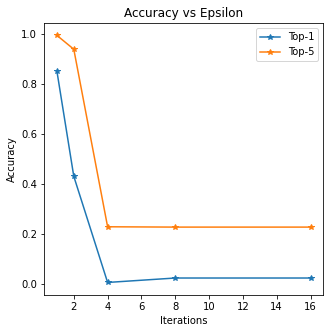

In [18]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, top1_accuracies, "*-", label="Top-1")
plt.plot(epsilons, top5_accuracies, "*-", label="Top-5")
plt.title("Accuracy vs Epsilon")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.show()

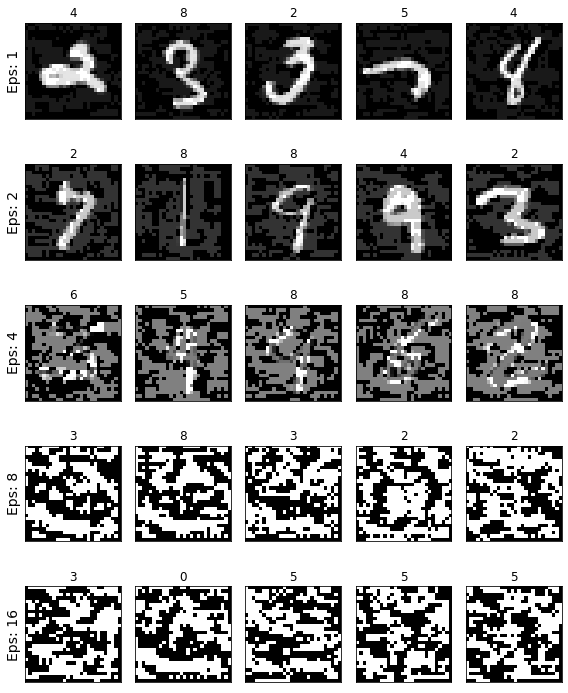

In [19]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        adv_label,ex = examples[i][j]
        plt.title(adv_label)
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()